In [8]:
#データの読み込み
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chapter09/train.txt', sep="\t")
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chapter09/test.txt', sep="\t")
valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/chapter09/valid.txt', sep="\t")
# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
CATEGORY
b    4502
e    4223
t    1219
m     728
Name: count, dtype: int64
検証データ
CATEGORY
b    562
e    528
t    153
m     91
Name: count, dtype: int64
評価データ
CATEGORY
b    563
e    528
t    152
m     91
Name: count, dtype: int64


In [9]:
# 単語の辞書を作成
from collections import Counter
words = []
for text in train['TITLE']:                #訓練データから文章を1つずつ取り出す
    for word in text.rstrip().split():     #文章を単語に分解
        words.append(word)                 #単語をリストに追加
c = Counter(words)                         #単語の出現回数を数える
print(c.most_common(10))                   #頻度上位10単語
word2id = {}                               #単語IDの辞書
for i, cnt in enumerate(c.most_common()):  #頻度上位10単語分繰り返す
    if cnt[1] > 1:                         #出現回数が1より大きい単語のみ
        word2id[cnt[0]] = i + 1            #辞書に単語とIDを紐付ける
for i, cnt in enumerate(word2id.items()):  #辞書の中身を確認
    if i >= 10:                            #10単語だけ表示
        break                              #for文を抜ける
    print(cnt[0], cnt[1])                  #単語とIDを表示

[('to', 2151), ('...', 2031), ('in', 1415), ('as', 1027), ('on', 1025), ('UPDATE', 1000), ('-', 991), ('for', 969), ('of', 957), ('The', 859)]
to 1
... 2
in 3
as 4
on 5
UPDATE 6
- 7
for 8
of 9
The 10


In [10]:
# 単語のID化
def tokenizer(text):                                 #単語IDのリストを返す関数
    words = text.rstrip().split()                    #単語に分解
    return [word2id.get(word, 0) for word in words]  #単語のIDに変換

sample = train.at[0, 'TITLE']                        #学習データの1つ目の文章
print(sample)                                        #文章を表示
print(tokenizer(sample))                             #文章を単語IDに変換

Justin Bieber Under Investigation For Attempted Robbery At Dave & Buster's
[66, 79, 733, 2094, 21, 4933, 6674, 35, 1514, 86, 0]


In [20]:
# RNNの作成
# モデルの構築
import random
import torch
from torch import nn
import torch.utils.data as data
from torchinfo import summary
import numpy as np

# 乱数のシードを設定
# parserなどで指定
seed = 1234

random.seed(seed)                                   # Python標準ライブラリの乱数のシードを設定
np.random.seed(seed)                                # Numpy乱数のシードを設定
torch.manual_seed(seed)                             # PyTorch乱数のシードを設定
torch.cuda.manual_seed(seed)                        # PyTorchのCUDA乱数のシードを設定
torch.backends.cudnn.benchmark = False              # PyTorchのCUDNNのベンチマークを使用しない  (cudnn内の非決定的な処理の固定化)
torch.backends.cudnn.deterministic = True           # PyTorchのCUDNNの定着を使用

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32      # 乱数生成のシードの初期値を設定
    np.random.seed(worker_seed)                     # Numpy乱数のシードを設定
    random.seed(worker_seed)                        # Python標準ライブラリの乱数のシードを設定

g = torch.Generator()                               # PyTorch乱数のシードを設定
g.manual_seed(seed)                                 # 乱数生成器にシードを設定

In [21]:
x = torch.tensor([tokenizer(sample)], dtype=torch.int64)                           # 文章を単語IDに変換
print(x)                                                                           # 文章をIDでを表示
print(x.size())                                                                    # 文章のサイズを確認

tensor([[  66,   79,  733, 2094,   21, 4933, 6674,   35, 1514,   86,    0]])
torch.Size([1, 11])


In [22]:
# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)
print(Y_train.size())
print(Y_train)

torch.Size([10672])
tensor([2, 0, 2,  ..., 0, 0, 0])


In [23]:
class NewsDataset(data.Dataset):
    """
    newsのDatasetクラス

    Attributes
    ----------------------------
    X : データフレーム
        単語ベクトルの平均をまとめたテンソル
    y : テンソル
        カテゴリをラベル化したテンソル
    phase : 'train' or 'val'
        学習か訓練かを設定する
    """
    def __init__(self, X, y, phase='train'):
        self.X = X['TITLE']
        self.y = y
        self.phase = phase

    def __len__(self):
        """全データサイズを返す"""
        return len(self.y)

    def __getitem__(self, idx):
        """idxに対応するテンソル形式のデータとラベルを取得"""
        inputs = torch.tensor(tokenizer(self.X[idx]))
        return inputs, self.y[idx]

train_dataset = NewsDataset(train, Y_train, phase='train')
valid_dataset = NewsDataset(valid, Y_valid, phase='val')
test_dataset = NewsDataset(test, Y_test, phase='val')
# 動作確認
idx = 0
print(train_dataset.__getitem__(idx)[0].size())
print(train_dataset.__getitem__(idx)[1])
print(valid_dataset.__getitem__(idx)[0].size())
print(valid_dataset.__getitem__(idx)[1])
print(test_dataset.__getitem__(idx)[0].size())
print(test_dataset.__getitem__(idx)[1])

torch.Size([11])
tensor(2)
torch.Size([11])
tensor(3)
torch.Size([13])
tensor(2)


In [24]:
def collate_fn(batch):
    sequences = [x[0] for x in batch]
    labels = torch.LongTensor([x[1] for x in batch])
    x = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PADDING_IDX)
    return x, labels

# DataLoaderを作成
batch_size = 64

train_dataloader = data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
valid_dataloader = data.DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)
test_dataloader = data.DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iter)
print(inputs)
print(labels)

tensor([[ 1136,   890,    22,  ..., 10327, 10327, 10327],
        [ 9241,   853,  8128,  ..., 10327, 10327, 10327],
        [  211,  1843,   104,  ..., 10327, 10327, 10327],
        ...,
        [ 2886,  4097,  5178,  ..., 10327, 10327, 10327],
        [ 2595,    40,  8576,  ..., 10327, 10327, 10327],
        [    6,     0,  3373,  ..., 10327, 10327, 10327]])
tensor([2, 2, 0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1,
        0, 0, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 3, 2, 3, 1, 2, 0, 2,
        0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 0])


In [25]:
from gensim.models import KeyedVectors

# 学習済みモデルのロード
file = '/content/drive/MyDrive/Colab Notebooks/chapter09/GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(file, binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.1, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 8340 / 10328
torch.Size([10328, 300])


In [26]:
def calc_acc(net, dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1) # ラベルを予想
            corrects += torch.sum(preds == labels.data).cpu()
    return corrects / len(dataloader.dataset)

In [27]:
# 学習を実行する
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.get_device_name())
    print("使用デバイス:", device)

    # ネットワークをgpuへ
    net.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおっくる
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc

In [30]:
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
        self.drop = nn.Dropout(0.4)
        self.fc = nn.Linear(out_channels, output_size)

    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        logits = self.fc(self.drop(max_pool.squeeze(2)))
        return logits

# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 2
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values())) + 1
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
x = torch.tensor([tokenizer(sample)], dtype=torch.int64)
print(x)
print(x.size())
print(nn.Softmax(dim=-1)(model(x)))

tensor([[  66,   79,  733, 2094,   21, 4933, 6674,   35, 1514,   86,    0]])
torch.Size([1, 11])
tensor([[0.2729, 0.2647, 0.2208, 0.2416]], grad_fn=<SoftmaxBackward0>)


Tesla T4
使用デバイス: cuda:0
Epoch 1 / 30 (train) Loss: 0.9699, Acc: 0.6132, (val) Loss: 0.7548, Acc: 0.7181
Epoch 2 / 30 (train) Loss: 0.6942, Acc: 0.7453, (val) Loss: 0.6485, Acc: 0.7699
Epoch 3 / 30 (train) Loss: 0.5403, Acc: 0.7974, (val) Loss: 0.5795, Acc: 0.7969
Epoch 4 / 30 (train) Loss: 0.4324, Acc: 0.8425, (val) Loss: 0.5405, Acc: 0.8043
Epoch 5 / 30 (train) Loss: 0.3512, Acc: 0.8739, (val) Loss: 0.5337, Acc: 0.8073
Epoch 6 / 30 (train) Loss: 0.2864, Acc: 0.8986, (val) Loss: 0.5201, Acc: 0.8148
Epoch 7 / 30 (train) Loss: 0.2615, Acc: 0.9084, (val) Loss: 0.5422, Acc: 0.8133
Epoch 8 / 30 (train) Loss: 0.2264, Acc: 0.9197, (val) Loss: 0.5515, Acc: 0.8141
Epoch 9 / 30 (train) Loss: 0.1831, Acc: 0.9343, (val) Loss: 0.5731, Acc: 0.8043
Epoch 10 / 30 (train) Loss: 0.1777, Acc: 0.9383, (val) Loss: 0.5723, Acc: 0.8103
Epoch 11 / 30 (train) Loss: 0.1577, Acc: 0.9444, (val) Loss: 0.5900, Acc: 0.8208
Epoch 12 / 30 (train) Loss: 0.1393, Acc: 0.9509, (val) Loss: 0.5838, Acc: 0.8238
Epoch 13 / 30

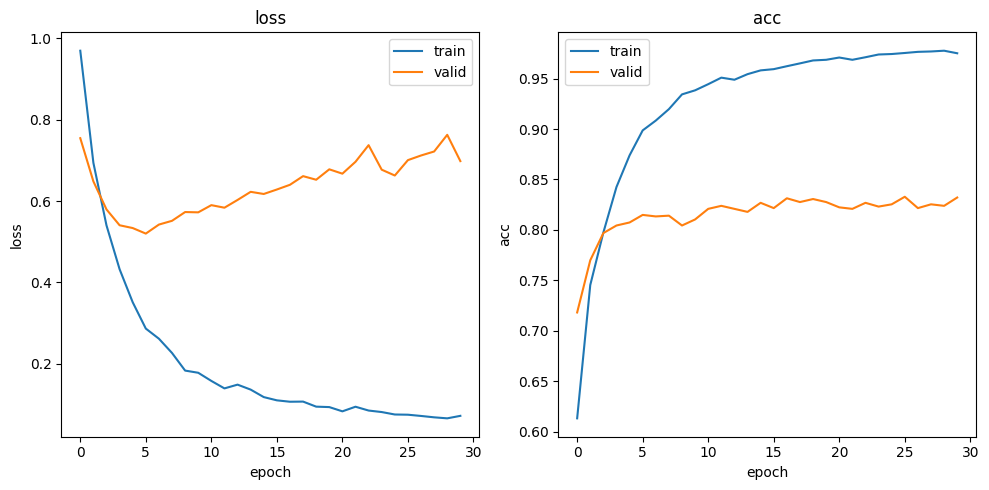

学習データの正解率: 0.9985
検証データの正解率: 0.8321
テストデータの正解率: 0.8403


In [33]:
# モデルの定義
net = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

num_epochs = 30
train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(num_epochs)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('fig87.png')
plt.show()

acc_train = calc_acc(net, train_dataloader)
acc_valid = calc_acc(net, valid_dataloader)
acc_test = calc_acc(net, test_dataloader)
print('学習データの正解率: {:.4f}'.format(acc_train))
print('検証データの正解率: {:.4f}'.format(acc_valid))
print('テストデータの正解率: {:.4f}'.format(acc_test))

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
pip install torchinfo